<img src="2000px-Ford_GoBike_logo.png" alt="Drawing" style="width: 400px;"/>

# Optimizing for Commuters and Increasing Ridership

<img src="IMG_0066.jpg" alt="Drawing" style="width: 500px;"/>

Ford GoBike is the Bay Area's bikeshare system, which aims to be a fast, convenient way to get around--whether you're commuting, running errands, or just sightseeing. Currently, the Bay Area ranks as 5th in the world for worst traffic and its transportation systems struggle to meet the demands of a fast growing population. Ford GoBike is poised to help alleviate the frustration of traffic congestion and transportation delays that many local commuters face on a daily basis. 

In this analysis, we aim to utilize the pilot program data to learn what are popular commuter routes and what potential offers will increase ridership in the system. We will use data from Google BigQuery stored in three tables: bikeshare_trips, bikeshare_status, and bikeshare_stations.

## Database Schema
### bikeshare_trips
| Field name         | Type       | Description                                                                                                  |
|--------------------|-----------|--------------------------------------------------------------------------------------------------------------|
| trip_id            | INTEGER   | Numeric ID of bike trip                                                                                      |
| duration_sec       | INTEGER   | Time of trip in seconds                                                                                      |
| start_date         | TIMESTAMP | Start date of trip with date and time, in PST                                                                |
| start_station_name | STRING    | Station name of start station                                                                                |
| start_station_id   | INTEGER   | Numeric reference for start station                                                                          |
| end_date           | TIMESTAMP | End date of trip with date and time, in PST                                                                  |
| end_station_name   | STRING    | Station name for end station                                                                                 |
| end_station_id     | INTEGER   | Numeric reference for end station                                                                            |
| bike_number        | INTEGER   | ID of bike used                                                                                              |
| zip_code           | STRING    | Home zip code of subscriber (customers can choose to manually enter zip at kiosk however data is unreliable) |
| subscriber_type    | STRING    | Subscriber = annual or 30-day member; Customer = 24-hour or 3-day member                                     |

### bikeshare_status
| Field name      | Type      | Description               |   |
|-----------------|-----------|---------------------------|---|
| station_id      | INTEGER   | Station ID number         |   |
| bikes_available | INTEGER   | Number of available bikes |   |
| docks_available | INTEGER   | Number of available docks |   |
| time            | TIMESTAMP | Date and time, PST        |   |

### bikeshare_stations
| Field name        | Type    | Description                                                                        |   |
|-------------------|---------|------------------------------------------------------------------------------------|---|
| station_id        | INTEGER | Station ID number                                                                  |   |
| name              | STRING  | Name of station                                                                    |   |
| latitude          | FLOAT   | Latitude                                                                           |   |
| longitude         | FLOAT   | Longitude                                                                          |   |
| dockcount         | INTEGER | Number of total docks at station                                                   |   |
| landmark          | STRING  | City (San Francisco, Redwood City, Palo Alto, Mountain View, San Jose)             |   |
| installation_date | DATE    | Original date that station was installed. If station was moved, it is noted below. |   |

In [8]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Question 1: What are the 5 most popular trips that you would call "commuter trips"?

First, I'll start broadly with the 5 most popular trips in the dataset and then dive into what commuter trips can look like. Initially when writing this query, I utilized the start_station_name and end_station_name columns located in bikeshare_trips. However, I found that these columns contain different spellings or phrasings of the station name, which may result incorrect groupings. 

For example, there are 74 distinct stations in the system, but a distinct count of the start_station_names in the bikeshare_trips table shows 84.

In [13]:
! bq query --use_legacy_sql=false 'SELECT COUNT (DISTINCT start_station_name) FROM `bigquery-public-data.san_francisco.bikeshare_trips`'

Waiting on bqjob_r65f1b10ce1d6dc24_00000168c65d8e24_1 ... (0s) Current status: DONE   
+-----+
| f0_ |
+-----+
|  84 |
+-----+


Thus, I found that it was more accurate to go by station_ids and join against the bikeshare_stations table twice to get the correct station name that way.

In [1]:
! bq query --use_legacy_sql=false 'SELECT start_station_id, a.name AS start_station_name, end_station_id, b.name AS end_station_name, COUNT(trip_id) AS count FROM `bigquery-public-data.san_francisco.bikeshare_trips` INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` AS a  ON `bigquery-public-data.san_francisco.bikeshare_trips`.start_station_id = a.station_id INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` AS b ON `bigquery-public-data.san_francisco.bikeshare_trips`.end_station_id = b.station_id GROUP BY start_station_id, end_station_id, a.name, b.name ORDER BY count DESC LIMIT 5'

Waiting on bqjob_r7324b412c84a0b87_00000168c530e561_1 ... (1s) Current status: DONE   
+------------------+-----------------------------------------+----------------+--------------------------------------+-------+
| start_station_id |           start_station_name            | end_station_id |           end_station_name           | count |
+------------------+-----------------------------------------+----------------+--------------------------------------+-------+
|               50 | Harry Bridges Plaza (Ferry Building)    |             60 | Embarcadero at Sansome               |  9150 |
|               69 | San Francisco Caltrain 2 (330 Townsend) |             65 | Townsend at 7th                      |  8508 |
|               61 | 2nd at Townsend                         |             50 | Harry Bridges Plaza (Ferry Building) |  7620 |
|               50 | Harry Bridges Plaza (Ferry Building)    |             61 | 2nd at Townsend                      |  6888 |
|               60 | Emb

Overall, the most popular trip routes are:

1. Harry Bridges Plaza (Ferry Building) to Embarcadero at Sansome
2. San Francisco Caltrain 2 (330 Townsend) to Townsend at 7th
3. 2nd at Townsend to Harry Bridges Plaza (Ferry Building)
4. Harry Bridges Plaza (Ferry Building) to 2nd at Townsend
5. Embarcadero at Sansome to Steuart at Market

However, to get to commuter trips, we must consider what type of data can help us distinguish users that are commuters. 

* Commuters are Bay Area local residents
    * We may be able to distinguish these users from those who are from out of town (visitors, tourists, etc.) the zip code column in bikeshare_trips
    * We will use Bay Area zip code data from https://catalog.data.gov/dataset/bay-area-zip-codes.
* There are typically two commuting periods: morning and evening during weekdays
    * We should specifically focus on these two time periods

In [36]:
# csv downloaded from website above
ba_zip = pd.read_csv('bayarea_zipcodes.csv')
ba_zip.head()

,PO_NAME,the_geom,ZIP,STATE,Area__,Length__
0,NAPA,MULTIPOLYGON (((-122.10329200180091 38.5132829...,94558,CA,1.231326e+10,995176.2253
1,FAIRFIELD,MULTIPOLYGON (((-121.947475002335 38.301511000...,94533,CA,9.917861e+08,200772.5566
2,DIXON,MULTIPOLYGON (((-121.65335500334429 38.3133870...,95620,CA,7.236950e+09,441860.2014
3,SONOMA,MULTIPOLYGON (((-122.406843003057 38.155681999...,95476,CA,3.001414e+09,311318.5463
4,NAPA,MULTIPOLYGON (((-122.29368500225117 38.1552379...,94559,CA,1.194302e+09,359104.6466


In [37]:
# get the zip column into a list for SQL query
zips = ba_zip['ZIP'].tolist()
# convert zips to strings because zip_code is varchar in bikeshare_trips
convert_zips = [str(z) for z in zips]

In [20]:
! bq query --use_legacy_sql=false 'SELECT COUNT(*) AS count FROM `bigquery-public-data.san_francisco.bikeshare_trips` WHERE LENGTH(zip_code) = 5 AND zip_code IN ("94558","94533","95620","95476","94559","94954","94571","94535","94503","94949","94945","94512","94591","94510","94592","94589","94947","94590","94946","94561","94525","94569","94585","94103","94565","94903","94520","94572","94553","94547","94963","94938","94502","94509","94960","94513","94109","94521","94930","94973","94933","94598","94564","94801","94519","94806","94901","94531","94803","94601","94523","94518","94904","94115","94549","94517","94805","94804","94939","94964","94530","94925","94596","94708","94105","94941","94563","94720","94707","94514","94970","94706","94710","94104","94595","94709","94703","94704","94507","94702","94965","94556","94920","94118","94705","94611","94618","94609","94550","94608","94528","94526","94506","94130","94607","94123","94610","94583","94602","94612","94546","94133","94129","94606","94111","94619","94121","94102","94552","94501","94108","94605","94613","94117","94122","94621","94114","94107","94110","94588","94131","94603","94116","94124","94127","94577","94132","94112","94134","94568","94578","94015","94005","94014","94579","94580","94541","94566","94542","94544","94044","94545","94586","94080","94587","94066","94128","94401","94019","94030","94555","94038","94010","94536","94539","94402","94404","94403","94538","94560","94065","94063","94027","94002","94070","95134","95002","94062","94089","94301","94025","94303","95035","95140","94061","94043","94304","94305","94035","94306","94028","94040","94022","94085","94086","94024","94087")'

Waiting on bqjob_r6834f92b320f9023_00000168c665a9f4_1 ... (0s) Current status: DONE   
+--------+
| count  |
+--------+
| 771244 |
+--------+


Documentation on the data noted that zip_code column data were not reliable since users enter it at the station. In exploring the data, I did find that there were many rows with erroneous data such as strings less than 5 digits or missing values. However, the query above shows that 78% of the rows did have proper Bay Area zip codes, so these trips are more likely to be commuter trips. Next, we examine the two commuting periods: morning and evening. For this analysis, we consider morning as 5:00 to 10:00 AM and evening as 3:00 to 8:00 PM.

In [31]:
# morning
! bq query --use_legacy_sql=false 'SELECT start_station_id, a.name AS start_station_name, end_station_id, b.name AS end_station_name, COUNT(trip_id) AS count FROM `bigquery-public-data.san_francisco.bikeshare_trips` INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` AS a  ON `bigquery-public-data.san_francisco.bikeshare_trips`.start_station_id = a.station_id INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` AS b ON `bigquery-public-data.san_francisco.bikeshare_trips`.end_station_id = b.station_id WHERE LENGTH(zip_code) = 5 AND zip_code IN ("94558","94533","95620","95476","94559","94954","94571","94535","94503","94949","94945","94512","94591","94510","94592","94589","94947","94590","94946","94561","94525","94569","94585","94103","94565","94903","94520","94572","94553","94547","94963","94938","94502","94509","94960","94513","94109","94521","94930","94973","94933","94598","94564","94801","94519","94806","94901","94531","94803","94601","94523","94518","94904","94115","94549","94517","94805","94804","94939","94964","94530","94925","94596","94708","94105","94941","94563","94720","94707","94514","94970","94706","94710","94104","94595","94709","94703","94704","94507","94702","94965","94556","94920","94118","94705","94611","94618","94609","94550","94608","94528","94526","94506","94130","94607","94123","94610","94583","94602","94612","94546","94133","94129","94606","94111","94619","94121","94102","94552","94501","94108","94605","94613","94117","94122","94621","94114","94107","94110","94588","94131","94603","94116","94124","94127","94577","94132","94112","94134","94568","94578","94015","94005","94014","94579","94580","94541","94566","94542","94544","94044","94545","94586","94080","94587","94066","94128","94401","94019","94030","94555","94038","94010","94536","94539","94402","94404","94403","94538","94560","94065","94063","94027","94002","94070","95134","95002","94062","94089","94301","94025","94303","95035","95140","94061","94043","94304","94305","94035","94306","94028","94040","94022","94085","94086","94024","94087") AND CAST(start_date AS time) BETWEEN "05:00:00" AND "9:59:00" AND EXTRACT(DAYOFWEEK FROM start_date) <= 6 GROUP BY start_station_id, end_station_id, a.name, b.name ORDER BY count DESC LIMIT 5'

Waiting on bqjob_r372e3d3691cdcde4_00000168c70bd099_1 ... (0s) Current status: DONE   
+------------------+------------------------------------------+----------------+-----------------------------------------------+-------+
| start_station_id |            start_station_name            | end_station_id |               end_station_name                | count |
+------------------+------------------------------------------+----------------+-----------------------------------------------+-------+
|               50 | Harry Bridges Plaza (Ferry Building)     |             61 | 2nd at Townsend                               |  4341 |
|               74 | Steuart at Market                        |             61 | 2nd at Townsend                               |  3692 |
|               70 | San Francisco Caltrain (Townsend at 4th) |             55 | Temporary Transbay Terminal (Howard at Beale) |  3050 |
|               77 | Market at Sansome                        |             64 | 2nd at Sou

In [32]:
# evening
! bq query --use_legacy_sql=false 'SELECT start_station_id, a.name AS start_station_name, end_station_id, b.name AS end_station_name, COUNT(trip_id) AS count FROM `bigquery-public-data.san_francisco.bikeshare_trips` INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` AS a  ON `bigquery-public-data.san_francisco.bikeshare_trips`.start_station_id = a.station_id INNER JOIN `bigquery-public-data.san_francisco.bikeshare_stations` AS b ON `bigquery-public-data.san_francisco.bikeshare_trips`.end_station_id = b.station_id WHERE LENGTH(zip_code) = 5 AND zip_code IN ("94558","94533","95620","95476","94559","94954","94571","94535","94503","94949","94945","94512","94591","94510","94592","94589","94947","94590","94946","94561","94525","94569","94585","94103","94565","94903","94520","94572","94553","94547","94963","94938","94502","94509","94960","94513","94109","94521","94930","94973","94933","94598","94564","94801","94519","94806","94901","94531","94803","94601","94523","94518","94904","94115","94549","94517","94805","94804","94939","94964","94530","94925","94596","94708","94105","94941","94563","94720","94707","94514","94970","94706","94710","94104","94595","94709","94703","94704","94507","94702","94965","94556","94920","94118","94705","94611","94618","94609","94550","94608","94528","94526","94506","94130","94607","94123","94610","94583","94602","94612","94546","94133","94129","94606","94111","94619","94121","94102","94552","94501","94108","94605","94613","94117","94122","94621","94114","94107","94110","94588","94131","94603","94116","94124","94127","94577","94132","94112","94134","94568","94578","94015","94005","94014","94579","94580","94541","94566","94542","94544","94044","94545","94586","94080","94587","94066","94128","94401","94019","94030","94555","94038","94010","94536","94539","94402","94404","94403","94538","94560","94065","94063","94027","94002","94070","95134","95002","94062","94089","94301","94025","94303","95035","95140","94061","94043","94304","94305","94035","94306","94028","94040","94022","94085","94086","94024","94087") AND CAST(start_date AS time) BETWEEN "15:00:00" AND "19:59:00" AND EXTRACT(DAYOFWEEK FROM start_date) <= 6 GROUP BY start_station_id, end_station_id, a.name, b.name ORDER BY count DESC LIMIT 5'

Waiting on bqjob_r2a90ec688a09d1db_00000168c70c4871_1 ... (0s) Current status: DONE   
+------------------+-----------------------------------------------+----------------+------------------------------------------+-------+
| start_station_id |              start_station_name               | end_station_id |             end_station_name             | count |
+------------------+-----------------------------------------------+----------------+------------------------------------------+-------+
|               61 | 2nd at Townsend                               |             50 | Harry Bridges Plaza (Ferry Building)     |  4487 |
|               60 | Embarcadero at Sansome                        |             74 | Steuart at Market                        |  3826 |
|               64 | 2nd at South Park                             |             77 | Market at Sansome                        |  3641 |
|               55 | Temporary Transbay Terminal (Howard at Beale) |             70 | San F

After filtering for attributes that could make trips considered "commuter", we arrive at the following results:

* **5 Most Popular Morning Commute Trips:**
    * Harry Bridges Plaza (Ferry Building) to 2nd at Townsend
    * Steuart at Market to 2nd at Townsend
    * San Francisco Caltrain (Townsend at 4th) to Temporary Transbay Terminal (Howard at Beale)
    * Market at Sansome to 2nd at South Park
    * Harry Bridges Plaza (Ferry Building) to Embarcadero at Sansome


* **5 Most Popular Evening Commute Trips:**
    * 2nd at Townsend to Harry Bridges Plaza (Ferry Building)
    * Embarcadero at Sansome to Steuart at Market
    * 2nd at South Park to Market at Sansome
    * Temporary Transbay Terminal (Howard at Beale) to San Francisco Caltrain (Townsend at 4th)
    * Townsend at 7th to San Francisco Caltrain 2 (330 Townsend)

We notice that the top trips for the morning and evening commutes are actually the reverse of each other. There are slight differences between these final results and the initial top 5 most popular trips we saw for all the trips, but one thing to note is that they are all San Francisco stations. The top trips for the morning and evening commutes feature more of start and end stations at local transportation hubs such as Caltrain and the Temporary Transbay Terminal. 

Given the high potential for demand during these two commuting periods, we should examine activity at the top stations more closely. We'll be looking at this broadly, without filtering for Bay Area zip codes, because we want to monitor overall activity.

For the morning commute, we observe that although the San Francisco Caltrain (70) has the highest number of average trips per day, it has the lowest dockcount of these top morning commute stations. Surprisingly, the Market at Sansome (77) station has an a much lower average than the other 3 stations despite have the highest dockcount. 

In [4]:
! bq query --use_legacy_sql=false 'SELECT a.station_id, a.name, a.dockcount, AVG(count) AS avg_trips_per_day FROM (SELECT station_id, name, dockcount, EXTRACT(DATE FROM start_date), COUNT(trip_id) AS count FROM `bigquery-public-data.san_francisco.bikeshare_stations` INNER JOIN `bigquery-public-data.san_francisco.bikeshare_trips` ON `bigquery-public-data.san_francisco.bikeshare_stations`.station_id = `bigquery-public-data.san_francisco.bikeshare_trips`.start_station_id WHERE station_id IN (50, 70, 74, 77) AND EXTRACT(DAYOFWEEK FROM start_date) <= 6 AND CAST(start_date AS time) BETWEEN "05:00:00" AND "9:59:00" GROUP BY station_id, name, dockcount, EXTRACT(DATE FROM start_date)) AS a GROUP BY a.station_id, a.name, a.dockcount'

Waiting on bqjob_r543ee526cc6d1f2d_00000168d03527d7_1 ... (1s) Current status: DONE   
+------------+------------------------------------------+-----------+--------------------+
| station_id |                   name                   | dockcount | avg_trips_per_day  |
+------------+------------------------------------------+-----------+--------------------+
|         70 | San Francisco Caltrain (Townsend at 4th) |        19 |  48.45952109464086 |
|         77 | Market at Sansome                        |        27 |  9.872289156626504 |
|         50 | Harry Bridges Plaza (Ferry Building)     |        23 |  24.29887640449438 |
|         74 | Steuart at Market                        |        23 | 18.651497005988027 |
+------------+------------------------------------------+-----------+--------------------+


For the evening commute, we observe relatively similar averages for each station within the range of 13-19 average trips per day in these peak hours. However, three of them only have 15 docks, which may have an impact on bike availability during evening hours. 

In [12]:
! bq query --use_legacy_sql=false 'SELECT a.station_id, a.name, a.dockcount, AVG(count) AS avg_trips_per_day FROM (SELECT station_id, name, dockcount, EXTRACT(DATE FROM start_date), COUNT(trip_id) AS count FROM `bigquery-public-data.san_francisco.bikeshare_stations` INNER JOIN `bigquery-public-data.san_francisco.bikeshare_trips` ON `bigquery-public-data.san_francisco.bikeshare_stations`.station_id = `bigquery-public-data.san_francisco.bikeshare_trips`.start_station_id WHERE station_id IN (61, 60, 64, 55, 65) AND EXTRACT(DAYOFWEEK FROM start_date) <= 6 AND CAST(start_date AS time) BETWEEN "15:00:00" AND "19:59:00" GROUP BY station_id, name, dockcount, EXTRACT(DATE FROM start_date)) AS a GROUP BY a.station_id, a.name, a.dockcount'

Waiting on bqjob_r71b261fb86c6af50_00000168d0468d46_1 ... (1s) Current status: DONE   
+------------+-----------------------------------------------+-----------+--------------------+
| station_id |                     name                      | dockcount | avg_trips_per_day  |
+------------+-----------------------------------------------+-----------+--------------------+
|         55 | Temporary Transbay Terminal (Howard at Beale) |        23 | 13.939799331103671 |
|         60 | Embarcadero at Sansome                        |        15 | 18.811099252934913 |
|         61 | 2nd at Townsend                               |        27 | 18.491397849462352 |
|         65 | Townsend at 7th                               |        15 |  19.86105032822756 |
|         64 | 2nd at South Park                             |        15 | 15.019165727170213 |
+------------+-----------------------------------------------+-----------+--------------------+


Next, we'll examine bike availability during these commuting periods, hour by hour. 

In [6]:
! bq query --use_legacy_sql=false --format=csv 'SELECT station_id, TIME_TRUNC(CAST(time as time), HOUR) hour, AVG(bikes_available) AS avg_bikes_avail  FROM `bigquery-public-data.san_francisco.bikeshare_status` WHERE CAST(time AS time) BETWEEN "05:00:00" AND "09:59:00" AND EXTRACT(DAYOFWEEK FROM time) <= 6 AND station_id IN (50, 70, 74, 77) GROUP BY station_id, hour ORDER BY station_id, hour' > morning_hours.csv

Waiting on bqjob_r1b7a249543fb835d_00000168d0424c0f_1 ... (8s) Current status: DONE   

In [54]:
morn_hours = pd.read_csv('morning_hours.csv')
#morn_hours.head()

From the chart below, we can see that bike availability tends to decrease in the hours of 8:00 and 9:00 AM, which is closer to the start of the work day. Given that some of these stations are near transportation hubs, this also could be because many users utilize other modes of transportation (Caltrain, Muni, BART, etc.) at the start of the commute and they utilize Ford GoBike for their last leg of the commute, which is closer to 8:00 - 10:00 AM. 

Text(0.5,1,'Average Bikes Available During Morning Commute for Top Stations')

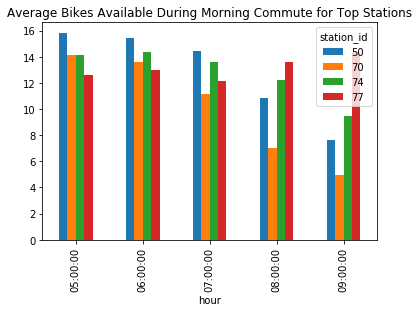

In [16]:
morn_hours.pivot(index='hour', columns='station_id', values='avg_bikes_avail').plot(kind='bar')
plt.title("Average Bikes Available During Morning Commute for Top Stations")

In [11]:
! bq query --use_legacy_sql=false --format=csv 'SELECT station_id, TIME_TRUNC(CAST(time as time), HOUR) hour, AVG(bikes_available) AS avg_bikes_avail  FROM `bigquery-public-data.san_francisco.bikeshare_status` WHERE CAST(time AS time) BETWEEN "15:00:00" AND "19:59:00" AND EXTRACT(DAYOFWEEK FROM time) <= 6 AND station_id IN (61, 60, 64, 55, 65) GROUP BY station_id, hour ORDER BY station_id, hour' > evening_hours.csv

Waiting on bqjob_ra69811a63181e46_00000168d04659c4_1 ... (7s) Current status: DONE   

In [55]:
eve_hours = pd.read_csv('evening_hours.csv')
#eve_hours.head()

For the evening commute, the Temporary Transbay Terminal (55) station initially starts out with low availability at the start of the commuting period and the bike availability appears to increase by 4:00 and 5:00 PM. The other stations maintain about 50% of their dock capacity in the same two hours with some slight decreases in the latter part of the evening commute. 

Text(0.5,1,'Average Bikes Available During Evening Commute for Top Stations')

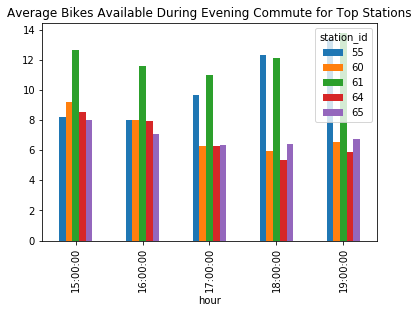

In [17]:
eve_hours.pivot(index='hour', columns='station_id', values='avg_bikes_avail').plot(kind='bar')
plt.title("Average Bikes Available During Evening Commute for Top Stations")

This hour-by-hour analysis is a first step into analyzing usage at popular commuter stations. Commuters have a greater chance of being Ford GoBike subscribers and with knowledge on the most popular routes, Ford GoBike can more effectively allocate resources to ensure bike availability and user satisfaction during high usage periods. This can also further the goal of increasing ridership.

## Question 2: What are your recommendations for offers to increase ridership?

Currently, Ford GoBike offers the following bikeshare plans: a flat price for a single one-way trip, a day pass that allows unlimited 30-minute rides for 24 hours and an annual membership. The system is available in 5 Bay Area cities: San Francisco, San Jose, Mountain View, Redwood City, and Palo Alto. While San Francisco hosts 50% of the total stations, it accounts for over 90% of the trips. 

In [33]:
! bq query --use_legacy_sql=false 'SELECT landmark, COUNT(DISTINCT station_id) AS station_count, COUNT(trip_id) AS trip_count FROM `bigquery-public-data.san_francisco.bikeshare_stations` INNER JOIN `bigquery-public-data.san_francisco.bikeshare_trips` ON `bigquery-public-data.san_francisco.bikeshare_stations`.station_id = `bigquery-public-data.san_francisco.bikeshare_trips`.start_station_id GROUP BY landmark ORDER BY station_count DESC'

Waiting on bqjob_rbbd125dc3cfb197_00000168cc6b092e_1 ... (1s) Current status: DONE   
+---------------+---------------+------------+
|   landmark    | station_count | trip_count |
+---------------+---------------+------------+
| San Francisco |            37 |     891223 |
| San Jose      |            18 |      52861 |
| Mountain View |             7 |      24679 |
| Redwood City  |             7 |       4996 |
| Palo Alto     |             5 |       9889 |
+---------------+---------------+------------+


When the system first launched in August 2013, 33 stations were installed in San Francisco while 28 stations were installed in other within the same month. Despite being established around the same time period, these stations do not have the same volume of trips as the comparable ones in San Francisco. Although there are many factors that contribute to why Ford GoBike is much more popular in San Francisco (larger population, tourism, more commuters, differences in marketing, etc.), it is worthwhile to consider how we can incentivize users to utilize Ford GoBike in the other cities.

In [4]:
! bq query --use_legacy_sql=false --format=csv 'SELECT start_station_id, a.name, a.landmark, a.installation_date, COUNT(*) AS trip_count FROM `bigquery-public-data.san_francisco.bikeshare_trips` INNER JOIN (SELECT station_id, name, landmark, installation_date FROM `bigquery-public-data.san_francisco.bikeshare_stations` WHERE EXTRACT(YEAR FROM installation_date) = 2013 AND EXTRACT(MONTH FROM installation_date) = 8) AS a ON `bigquery-public-data.san_francisco.bikeshare_trips`.start_station_id = a.station_id GROUP BY start_station_id, a.name, a.landmark, a.installation_date ORDER BY trip_count DESC' > earliest_stations.csv

Waiting on bqjob_r1d1aead9f0d1a1c6_00000168cc376163_1 ... (0s) Current status: DONE   

Text(0.5,0,'Number of Trips')

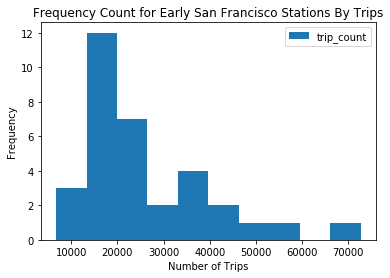

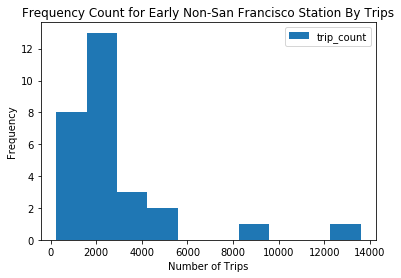

In [34]:
# read into pandas
early_stations = pd.read_csv('earliest_stations.csv')
df = early_stations[['landmark', 'trip_count']]

df[df['landmark'] == 'San Francisco'].plot.hist()
plt.title('Frequency Count for Early San Francisco Stations By Trips')
plt.xlabel('Number of Trips')

df[df['landmark'] != 'San Francisco'].plot.hist()
plt.title('Frequency Count for Early Non-San Francisco Station By Trips')
plt.xlabel('Number of Trips')

We also find that there are differences in the trip durations by city. Most strikingly, the average trip duration in Palo Alto is over 60 minutes which is much higher than that of the other cities. We will examine trip duration with grouped intervals in cities besides San Francisco with histograms to get a better sense of the distributions.

In [40]:
! bq query --use_legacy_sql=false 'SELECT landmark, COUNT(*) AS count, AVG(duration_sec/60) AS avg_trip FROM `bigquery-public-data.san_francisco.bikeshare_stations` INNER JOIN `bigquery-public-data.san_francisco.bikeshare_trips` ON `bigquery-public-data.san_francisco.bikeshare_stations`.station_id = `bigquery-public-data.san_francisco.bikeshare_trips`.start_station_id GROUP BY landmark ORDER BY count DESC'

Waiting on bqjob_r7ccea2622c5aa060_00000168c7299f78_1 ... (0s) Current status: DONE   
+---------------+--------+--------------------+
|   landmark    | count  |      avg_trip      |
+---------------+--------+--------------------+
| San Francisco | 891223 | 15.922197493406236 |
| San Jose      |  52861 |  20.85189522206048 |
| Mountain View |  24679 |  26.30697354025692 |
| Palo Alto     |   9889 | 60.051228637880364 |
| Redwood City  |   4996 |  33.81819455564454 |
+---------------+--------+--------------------+


In [45]:
! bq query --use_legacy_sql=false --format=csv 'SELECT landmark, CASE WHEN duration_sec/60 < 10 THEN "0-9" WHEN duration_sec/60 < 20 THEN "10-19" WHEN duration_sec/60 < 30 THEN "20-29" WHEN duration_sec/60 < 40 THEN "30-39" WHEN duration_sec/60 < 50 THEN "40-49" WHEN duration_sec/60 < 60 THEN "50-59" WHEN duration_sec/60 >= 60 THEN "60 +" END AS trip_mins, COUNT(trip_id) AS count FROM `bigquery-public-data.san_francisco.bikeshare_stations` INNER JOIN `bigquery-public-data.san_francisco.bikeshare_trips` ON `bigquery-public-data.san_francisco.bikeshare_stations`.station_id = `bigquery-public-data.san_francisco.bikeshare_trips`.start_station_id GROUP BY landmark, trip_mins ORDER BY landmark, trip_mins' > durations.csv

Waiting on bqjob_r5fff75d2045b78c3_00000168d080042a_1 ... (1s) Current status: DONE   

The histograms show that while trips that take less than 10 minutes are the most common in all of the cities, there is more variation in trip duration in Palo Alto especially and it also has a higher portion of trips that last 60 minutes or more.

In [53]:
durations = pd.read_csv('durations.csv')
#durations.head()

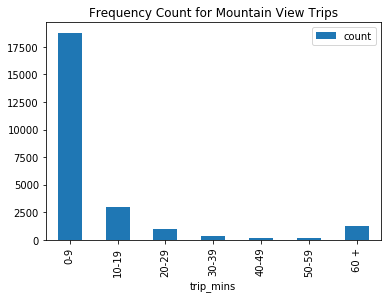

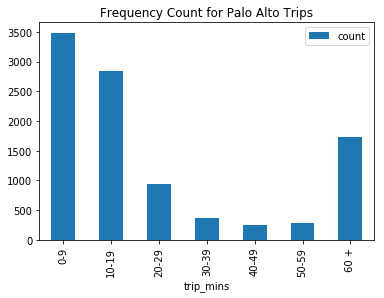

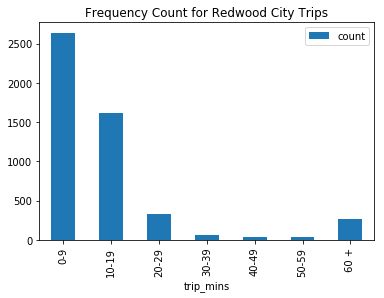

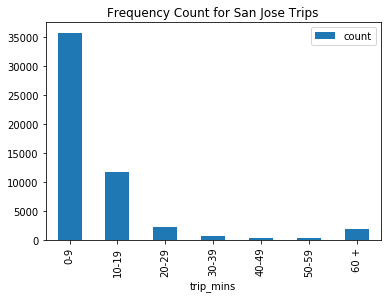

In [52]:
durations[durations['landmark'] == 'Mountain View'].plot(x='trip_mins', kind='bar', title='Frequency Count for Mountain View Trips')

durations[durations['landmark'] == 'Palo Alto'].plot(x='trip_mins', kind='bar', title='Frequency Count for Palo Alto Trips')

durations[durations['landmark'] == 'Redwood City'].plot(x='trip_mins', kind='bar', title='Frequency Count for Redwood City Trips')

durations[durations['landmark'] == 'San Jose'].plot(x='trip_mins', kind='bar', title='Frequency Count for San Jose Trips')

Based on this analysis, the following recommendations could serve to increase ridership in cities outside of San Francisco. 

* Offer different pricing for different cities
    * Although there are advantages to having plans for Bay Area as a whole, the data show that there's differential usage throughout the system.
        * Customize the single-way ticket prices to individual cities since single-way trips are most likely to end in the same city. In particular, we should reduce prices in cities with less trips such as Redwood City and Palo Alto.
        * Offer single city day passes and annual memberships. There may be users who know that they will only utilize Ford GoBike in one city and we can offer users the option of upgrading their plan or paying an small fee if they need to use it in another city. 
        * Maintain the current options that allow users to utilize their plans in the Bay Area as a whole.
        
* Set different trip duration limits by city
    * Currently, the trip duration limit is 30 minutes with fees incurring every 15 minutes after. As we saw in our analysis, in Palo Alto, trips close to an hour are more common. Given the current demand for bikes in Palo Alto, it's possible to extend trip duration limits without sacrificing resources while potentially fostering higher customer satisfaction.
   
* Collaborate with other transportation systems such as Caltrain, Muni, BART, AC Transit, and VTA, especially for special events
    * We noticed a trend of high usage of Ford GoBike at transportation hubs such as Caltrain or the Temporary Transbay Terminal. It's likely that many subscribers and customers utilize bikes as a "connector" with these other modes of transportation to get to where they need to go. Systems like Caltrain and BART having been struggling with increased demand due to the higher amounts of riders, which is especially apparently during special events like Warriors games or Bay to Breakers. Ford GoBike should foster relationships with these systems to increase awareness, which may help with the other systems manage the volume of ridership as well.

Citations: 
https://www.fordgobike.com/